In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append(".")
from model.class_xc330 import xc330

# from class_grp import grp
%matplotlib inline
print ("PACKAGES LOADED.")

FINGER_NUM =1


['/home/terry-q/Rilab/sOftrobot/SORO-Dynamixel-python', '', '/home/terry-q/catkin_ws/devel/lib/python3/dist-packages', '/opt/ros/noetic/lib/python3/dist-packages', '/home/terry-q/.pyenv/versions/2.7.16/lib/python27.zip', '/home/terry-q/.pyenv/versions/2.7.16/lib/python2.7', '/home/terry-q/.pyenv/versions/2.7.16/lib/python2.7/plat-linux2', '/home/terry-q/.pyenv/versions/2.7.16/lib/python2.7/lib-tk', '/home/terry-q/.pyenv/versions/2.7.16/lib/python2.7/lib-old', '/home/terry-q/.pyenv/versions/2.7.16/lib/python2.7/lib-dynload', '/home/terry-q/.pyenv/versions/2.7.16/envs/soro/lib/python2.7/site-packages', '/home/terry-q/.pyenv/versions/2.7.16/envs/soro/lib/python2.7/site-packages/IPython/extensions', '/home/terry-q/.ipython', '.']
PACKAGES LOADED.


In [2]:
!echo 'qwer1234'| sudo -S chmod a+rw /dev/ttyUSB0

[sudo] password for terry-q: 

## INSTANTIATE XL320 

In [3]:
snapbot = xc330('SNAPBOT', _USB_NUM=0)

[SNAPBOT] INSTANTIATED AT [/dev/ttyUSB0]


## Connect

In [4]:
snapbot.connect()

[SNAPBOT] CONNECT
 SUCCEEDED TO OPEN THE PORT!
 SUCCEEDED TO CHANGE THE BAUDRATE!
COMMUNICATION SUCCESS
[SNAPBOT] DETECT ID
[SNAPBOT] [4]MOTORS DETECTED 
[SNAPBOT] ID_LIST:[[13, 14, 15, 16]]


In [5]:
snapbot.set_torque([1])
print ("TORQUE ON")
snapbot.set_operatingmode([4])


TORQUE ON


## set Min/Max

In [6]:
print ("INITIALIZE POSITION")
currpos = snapbot.get_currpos()
print (currpos)

minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)

INITIALIZE POSITION
[1455 1671 2289 1765]


In [18]:
MoveSize = 1000
# Calpos = currpos +np.array([1,0,0,0]*FINGER_NUM)*MoveSize
# snapbot.set_goalposcluster(Calpos,1)
# time.sleep(3)

# Calpos = currpos +np.array([0,-1,0,0]*FINGER_NUM)*MoveSize
# snapbot.set_goalposcluster(Calpos,1)
# time.sleep(3)

Calpos = currpos +np.array([0,0,1,0]*FINGER_NUM)*MoveSize
snapbot.set_goalposcluster(Calpos,1)
time.sleep(3)

# Calpos = currpos +np.array([0,0,0,-1]*FINGER_NUM)*MoveSize
# snapbot.set_goalposcluster(Calpos,1)
# time.sleep(3)


## Go to ZeroPos

In [ ]:
snapbot.set_goalpos(currpos)

## KalmanFilter

In [22]:
def signedint2int(signedints):
    signedints = np.asarray(signedints)
    plainInts = np.zeros_like(signedints)
    for idx,signedint in enumerate(signedints):
        assert 0<=signedint and signedint<2**16
        if signedint > 2**15:
            plainInt = signedint - 2**16
        else:
            plainInt = signedint
        plainInts[idx] = plainInt
    return plainInts

In [19]:
class KalmanFilterClass(object):
    def __init__(self,name='kf',dt=0.05,q_x=0.1,q_v=0.1,r_y=1.0,y_init=0.0):
        self.name = name
        self.dt = dt
        self.q_x = q_x
        self.q_v = q_v
        self.r_y = r_y
        self.y_init = y_init
        # Initialize some internal variables
        self.Q = np.array([[self.q_x,0],[0,self.q_v]])
        self.R = np.array(self.r_y)
        self.H = np.array([[1,0]])
        self.F = np.array([[1,self.dt],[0,1]])
        #
        self.x_hat = np.array([[self.y_init],[0]])
        self.P_hat = self.Q
        self.y = self.y_init
        
    # Update Kalman Filter
    def update(self,y):
        x_hat_m = np.matmul(self.F,self.x_hat)
        P_hat_m = np.matmul(np.matmul(self.F,self.P_hat),self.F.T) + self.Q
        W = np.linalg.inv(np.matmul(np.matmul(self.H,P_hat_m),self.H.T)+self.R)
        K = np.matmul(np.matmul(P_hat_m, self.H.T),W)
        # Update
        self.x_hat = self.x_hat + np.matmul(K,y-np.matmul(self.H,x_hat_m))
        self.P_hat = P_hat_m - np.matmul(np.matmul(K,self.H),P_hat_m)

## estimate

In [116]:
# Realse Tension
snapbot.set_torque([0])
time.sleep(2)
snapbot.set_torque([1])

# set currentpos
currpos = snapbot.get_currpos()
minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)
initpos = snapbot.get_currpos()

In [122]:
print ("INITIALIZE POSITION")

currpos = snapbot.get_currpos()
length = currpos.shape[0]
numiter = 10
predPlots = np.zeros(length*numiter).reshape(length,numiter)

maxtime = 500
Errorbound = 1
# Kp = 2
# Kd = 0.02
Kp = 2
Kd = 1
currentTarget = np.array([1,-1,2,-1]*FINGER_NUM)*15
currentErrors = np.zeros(maxtime*length).reshape(maxtime,currentTarget.shape[0])
pos = snapbot.get_currpos()
iteration = 0
warmiteration = 100
KalmanFilters = []

# Warm up Sequence
for i in range(length):
    name = "current" + str(i)
    KalmanFilter = KalmanFilterClass(name=name,dt=0.05,q_x=0.1,q_v=0.1,r_y=2.0,y_init=0.0)
    KalmanFilters.append(KalmanFilter)

for num in range(warmiteration):
    cur = snapbot.get_currcurr()
    cur = signedint2int(cur)
    
    for idx,(KalmanFilter,Singlecur) in enumerate(zip(KalmanFilters,cur)):
        # updatevalues[idx,i] = Singlecur
        KalmanFilter.update(Singlecur)

    
        pred = KalmanFilter.x_hat[0] + KalmanFilter.x_hat[1]*KalmanFilter.dt*2
    
        # predPlots[idx,i] = pred
        
    time.sleep(0.01)
print("Warm up Done!")

while True:
    snapbot.set_torque([1])
    snapbot.set_goalpos(pos)
    
    #Calibrate
    
    
    # updatevalues = np.zeros(length*numiter).reshape(length,numiter)
    # predPlots = np.zeros(length*numiter).reshape(length,numiter)

    for i in range(numiter):
        
        cur = snapbot.get_currcurr()
        cur = signedint2int(cur)
        
        for idx,(KalmanFilter,Singlecur) in enumerate(zip(KalmanFilters,cur)):
            # updatevalues[idx,i] = Singlecur
            KalmanFilter.update(Singlecur)

        
            pred = KalmanFilter.x_hat[0] + KalmanFilter.x_hat[1]*KalmanFilter.dt*2
        
            predPlots[idx,i] = pred
    
    
    time.sleep(0.1)
    
    currentError = currentTarget - predPlots[:,-1]
    
    currentErrors[iteration] = currentError
    
    P = currentError
    
    if iteration==0:
        D = 0
    else:
        D = currentErrors[iteration] - currentErrors[iteration-1]
    
    deltaX = Kp * P - Kd * D
    deltaX = np.where(abs(currentError)<Errorbound,0,deltaX)
    
    pos = pos+deltaX
    pos = pos.astype(np.int)
    if (abs(currentError)<Errorbound).all():
        break
    
    iteration = iteration+1
    if iteration>=maxtime:
        print("Reached maximum Iteration")
        break

print ("INITIALIZE POSITION")
currpos = snapbot.get_currpos()
print (currpos)

minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)
initpos = snapbot.get_currpos()

INITIALIZE POSITION
Warm up Done!
INITIALIZE POSITION
[1695 1443 2725 1502]


## Custom Calibrate

In [126]:
l1 = 0
l2 = 0
l3 = 0
l4 = 0
Calpos = currpos +np.array([l1,-l2,l3,-l4]*FINGER_NUM)
snapbot.set_goalposcluster(Calpos,1)


## Plot

[ 13.82710862 -12.13228792  30.22880359 -14.73929139]


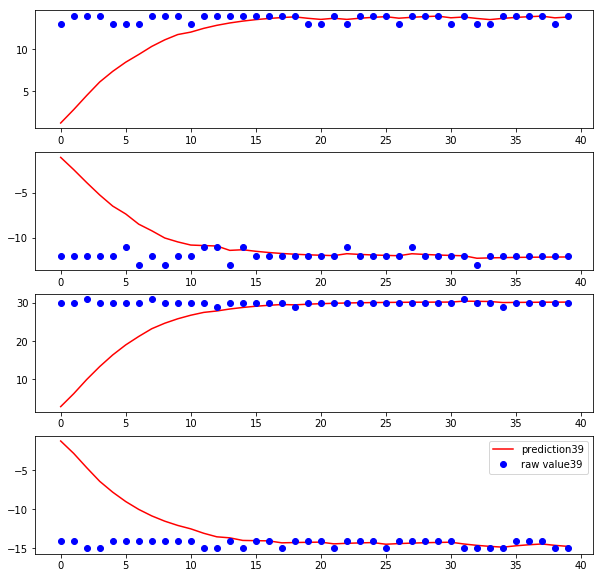

In [123]:
KalmanFilters = []
for i in range(length):
    name = "current" + str(i)
    KalmanFilter = KalmanFilterClass(name=name,dt=0.05,q_x=0.1,q_v=0.1,r_y=2.0,y_init=0.0)
    KalmanFilters.append(KalmanFilter)
#Calibrate
# ls = np.zeros(10*3).reshape(10,3)
numiter = 40
updatevalues = np.zeros(length*numiter).reshape(length,numiter)
predPlots = np.zeros(length*numiter).reshape(length,numiter)

for i in range(numiter):
    cur = snapbot.get_currcurr()
    cur = signedint2int(cur)
    
    for idx,(KalmanFilter,Singlecur) in enumerate(zip(KalmanFilters,cur)):
        updatevalues[idx,i] = Singlecur
        KalmanFilter.update(Singlecur)

        
        pred = KalmanFilter.x_hat[0] + KalmanFilter.x_hat[1]*KalmanFilter.dt*2   
        
        predPlots[idx,i] = pred
        
    time.sleep(0.1)

figure, axis = plt.subplots(4,1,figsize=(10,10))
for idx,(updatevalue,predPlot) in enumerate(zip(updatevalues,predPlots)):
    axis[idx].plot(predPlot,'r-', label='prediction'+str(i))
    axis[idx].plot(updatevalue,'ob',label='raw value'+str(i))

print(predPlots[:,-1])
plt.legend()
plt.show()